### Построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска.

In [ ]:
#pip install pandas catboost lightgbm shap numpy numba swifter pymystem3 nltk

In [47]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc
from tqdm import tqdm
from IPython.core.display import display, HTML
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from random import Random
from dateutil.parser import parse
import shap
pd.set_option('precision', 2)
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
display(HTML("<style>.container { width:100% !important;}</style>"))
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [48]:
# Объединим трейн и тест в один датасет:
data = pd.concat([pd.read_csv('train_dataset_hackathon_mkb.csv',encoding='cp1251', sep=';'),
                  pd.read_csv('test_dataset_hackathon_mkb.csv',encoding='cp1251', sep=';')]).reset_index(drop=True)

In [49]:
# Проверим, отсортирован ли датасет по contract_id (1 - да, 0 -нет):
data['id_contract'].diff().nunique()

1

In [52]:
from itertools import combinations

# Определим признаки, содержащие финансовые показатели поставщика на текущий период:
finance_cols = data.columns[5:50]

# Рассчитаем все отношения финансовых показателей друг к другу:
for combo in list(combinations(list(finance_cols), 2)):
    data['{}/{}'.format(combo[0], combo[1])] = data[combo[0]] / data[combo[1]]

# Переведём категории диапазонов численности персонала в количественный признак, сохранив порядок.
data['WORKERSRANGE'] = data['WORKERSRANGE'].fillna('-1 ').apply(lambda x: int(x.split(' ')[0]))

# Переведём признаки с датой в формат datetime:
for col in ['DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE', 'SIGN_DATE']:
    data[col] = pd.to_datetime(data[col].fillna('01JAN2000:00:00:00').apply(lambda x: parse(x.split(':')[0])))

# Рассчитаем таймдельты для всех 4-х дат:
for combo in list(combinations(['SIGN_DATE', 'DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE'], 2)):
    data['{}-{}'.format(combo[0], combo[1])] = (data[combo[0]] - data[combo[1]]).dt.days

data['dayofyear'] = 0
data['dayofyear'] = data['SIGN_DATE'].dt.dayofyear

# Загрузим справочник ОКВЭД с детальным описанием кодов:
okved = pd.read_csv('code_full.csv', sep=',')  # источник: https://github.com/Datasciensyash/Okved_Dataset

# Создадим 5 категориальных признаков на основе ОКВЭД: класс>подкласс>группа>подгруппа>вид 
# Все пустые значения заполняем значением с уровня ниже (см. результат в следующей ячейке)

okved_dict = dict(zip(okved['Code'].astype(str).str.strip(), okved['Description']))
data[['OKVED2', 'OKVED2sub', 'OKVED3sub']] = np.nan

data['OKVED'] = data['OKVED_CODE'].apply(lambda x: str(x).split('.')[0])
data['len_okved'] = data['OKVED_CODE'].apply(lambda x: len(str(x)))
data.loc[data['len_okved'] > 3, 'OKVED2'] = data.loc[data['len_okved'] > 3, 'OKVED_CODE'].apply(
    lambda x: str(x).split('.')[0] + '.' + str(x).split('.')[1])
data.loc[data['OKVED2'].isna(), 'OKVED2'] = data['OKVED']
data['OKVED_TEXT'] = data['OKVED'].map(okved_dict).fillna('')
data['OKVED_TEXT2'] = data['OKVED_CODE'].map(okved_dict).fillna('')
data['OKVED_TEXT3'] = data['OKVED2'].map(okved_dict).fillna('')

data.loc[data['len_okved'] > 4, 'OKVED2sub'] = data.loc[data['len_okved'] > 4, 'OKVED_CODE'].apply(
    lambda x: str(x).split('.')[0] + '.' + str(x).split('.')[1][0])
data.loc[(data['OKVED2sub'].isna()) & (data['len_okved'] == 4), 'OKVED2sub'] = data['OKVED2'].str[:4]
data.loc[data['OKVED2sub'].isna(), 'OKVED2sub'] = data['OKVED']

data.loc[data['len_okved'] > 7, 'OKVED3sub'] = data.loc[data['len_okved'] > 7, 'OKVED_CODE'].apply(
    lambda x: str(x).split('.')[0] + '.' + str(x).split('.')[1] + '.' + str(x).split('.')[2][0])
data.loc[(data['OKVED3sub'].isna()) & (data['len_okved'] == 7), 'OKVED3sub'] = data['OKVED_CODE'].str[:7]
data.loc[data['OKVED3sub'].isna(), 'OKVED3sub'] = data['OKVED2']

# Добавим признак отношения к одному из 21 раздела справочника ОКВЭД: (строительство, здравоохранение, торговля и т.д)
data['SECTION'] = data['OKVED_CODE'].map(dict(zip(okved['Code'].astype(str).str.strip(), okved['Section']))).fillna('')

CPU times: user 4 s, sys: 11.4 ms, total: 4.01 s
Wall time: 4.07 s


In [53]:
data[['OKVED_CODE','OKVED','OKVED2sub','OKVED2','OKVED3sub','SECTION','OKVED_TEXT','OKVED_TEXT2','OKVED_TEXT3']].sample(10)

,OKVED_CODE,OKVED,OKVED2sub,OKVED2,OKVED3sub,SECTION,OKVED_TEXT,OKVED_TEXT2,OKVED_TEXT3
22619,56.29,56,56.2,56.29,56.29,I,Деятельность по предоставлению продуктов питан...,Деятельность предприятий общественного питания...,Деятельность предприятий общественного питания...
12289,46.39,46,46.3,46.39,46.39,G,"Торговля оптовая, кроме оптовой торговли автот...",Торговля оптовая неспециализированная пищевыми...,Торговля оптовая неспециализированная пищевыми...
2248,45.1,45,45.1,45.1,45.1,G,Торговля оптовая и розничная автотранспортными...,Торговля автотранспортными средствами ...,Торговля автотранспортными средствами ...
12273,46.46,46,46.4,46.46,46.46,G,"Торговля оптовая, кроме оптовой торговли автот...",Торговля оптовая фармацевтической продукцией ...,Торговля оптовая фармацевтической продукцией ...
10069,43.99,43,43.9,43.99,43.99,F,Работы строительные специализированные ...,"Работы строительные специализированные прочие,...","Работы строительные специализированные прочие,..."
9214,72.19,72,72.1,72.19,72.19,M,Научные исследования и разработки ...,Научные исследования и разработки в области ес...,Научные исследования и разработки в области ес...
11198,46.32.1,46,46.3,46.32,46.32.1,G,"Торговля оптовая, кроме оптовой торговли автот...","Торговля оптовая мясом и мясом птицы, включая ...",Торговля оптовая мясом и мясными продуктами ...
5183,46.31,46,46.3,46.31,46.31,G,"Торговля оптовая, кроме оптовой торговли автот...",Торговля оптовая фруктами и овощами ...,Торговля оптовая фруктами и овощами ...
2440,71.1,71,71.1,71.1,71.1,M,Деятельность в области архитектуры и инженерно...,"Деятельность в области архитектуры, инженерных...","Деятельность в области архитектуры, инженерных..."
19552,46.46.1,46,46.4,46.46,46.46.1,G,"Торговля оптовая, кроме оптовой торговли автот...",Торговля оптовая фармацевтической продукцией ...,Торговля оптовая фармацевтической продукцией ...


In [ ]:
# Рассчитаем среднюю периодичность (в днях) между фактами изменения в наименовании и ОПФ:
data['SIGN_DATE-DATEFIRSTREG/COUNT_CHANGE_EVER'] = data['SIGN_DATE-DATEFIRSTREG'] / data['COUNT_CHANGE_EVER']

# Рассчитаем среднюю периодичность по другим харакетристикам:
for col in ['PLAINTIFF_CASESNUMBER_EVER', 'PLAINTIFF_SUM_EVER', 'DEFENDANT_CASESNUMBER_EVER', 'DEFENDANT_SUM_EVER',
            'THIRDOROTHERPERSON_EVER']:
    data['ratio1_SIGN_DATE-DATEFIRSTREG/{}'.format(col)] = data['SIGN_DATE-DATEFIRSTREG'] / data[col]  # -//-//-

for col in ['ADMITTEDNUMBER_233_EVER', 'NOTADMITTEDNUMBER_233_EVER', 'WINNERNUMBER_233_EVER', 'SIGNEDNUMBER_233_EVER',
            'SUM_233_EVER']:
    data['ratio2_SIGN_DATE-DATEFIRSTREG/{}'.format(col)] = data['SIGN_DATE-DATEFIRSTREG'] / data[col]

for col in ['ADMITTEDNUMBER_95_EVER', 'NOTADMITTEDNUMBER_EVER', 'WINNERNUMBER_95_EVER', 'SIGNEDNUMBER_95_EVER',
            'SUM_95_EVER']:
    data['ratio3_SIGN_DATE-DATEFIRSTREG/{}'.format(col)] = data['SIGN_DATE-DATEFIRSTREG'] / data[col]

# Рассчитаем отношения между полученными средними периодами:
for r in ['ratio1', 'ratio2', 'ratio3']:
    combos = list(combinations([c for c in data.columns if r in c], 2))
    for combo in combos:
        data['r{}_{}/{}'.format(r[-1], combo[0], combo[1])] = data[combo[0]] / data[combo[1]]

# Рассчитаем отношения между количественными характеристиками участия в закупках:
for l in [['ADMITTEDNUMBER_233_YEAR', 'NOTADMITTEDNUMBER_233_YEAR',
           'WINNERNUMBER_233_YEAR', 'SIGNEDNUMBER_233_YEAR', 'SUM_233_YEAR'],
          ['ADMITTEDNUMBER_233_EVER', 'NOTADMITTEDNUMBER_233_EVER',
           'WINNERNUMBER_233_EVER', 'SIGNEDNUMBER_233_EVER', 'SUM_233_EVER'],
          ['PLAINTIFF_CASESNUMBER_YEAR', 'PLAINTIFF_SUM_YEAR',
           'DEFENDANT_CASESNUMBER_YEAR', 'DEFENDANT_SUM_YEAR', 'THIRDOROTHERPERSON_YEAR'],
          ['ADMITTEDNUMBER_95_YEAR', 'NOTADMITTEDNUMBER_95_YEAR',
           'WINNERNUMBER_95_YEAR', 'SIGNEDNUMBER_95_YEAR', 'SUM_95_YEAR'],
          ['ADMITTEDNUMBER_95_EVER', 'NOTADMITTEDNUMBER_EVER',
           'WINNERNUMBER_95_EVER', 'SIGNEDNUMBER_95_EVER', 'SUM_95_EVER']]:
    combos = list(combinations(l, 2))
    for combo in combos:
        data['{}/{}'.format(combo[0], combo[1])] = data[combo[0]] / data[combo[1]]

# Рассчитаем отношения между однородными количественными характеристиками участия в закупках по 223-ФЗ и 94-ФЗ:        
data['ADMITTEDNUMBER_233_YEAR/ADMITTEDNUMBER_95_YEAR'] = data['ADMITTEDNUMBER_233_YEAR'] / data[
    'ADMITTEDNUMBER_95_YEAR']
data['NOTADMITTEDNUMBER_233_YEAR/NOTADMITTEDNUMBER_95_YEAR'] = data['NOTADMITTEDNUMBER_233_YEAR'] / data[
    'NOTADMITTEDNUMBER_95_YEAR']
data['WINNERNUMBER_233_YEAR/WINNERNUMBER_95_YEAR'] = data['WINNERNUMBER_233_YEAR'] / data['WINNERNUMBER_95_YEAR']
data['SIGNEDNUMBER_233_YEAR/SIGNEDNUMBER_95_YEAR'] = data['SIGNEDNUMBER_233_YEAR'] / data['SIGNEDNUMBER_95_YEAR']
data['SUM_233_YEAR/SUM_95_YEAR'] = data['SUM_233_YEAR'] / data['SUM_95_YEAR']
data['ADMITTEDNUMBER_233_EVER/ADMITTEDNUMBER_95_EVER'] = data['ADMITTEDNUMBER_233_EVER'] / data[
    'ADMITTEDNUMBER_95_EVER']
data['NOTADMITTEDNUMBER_233_EVER/NOTADMITTEDNUMBER_EVER'] = data['NOTADMITTEDNUMBER_233_EVER'] / data[
    'NOTADMITTEDNUMBER_EVER']
data['WINNERNUMBER_233_EVER/WINNERNUMBER_95_EVER'] = data['WINNERNUMBER_233_EVER'] / data['WINNERNUMBER_95_EVER']
data['SIGNEDNUMBER_233_EVER/SIGNEDNUMBER_95_EVER'] = data['SIGNEDNUMBER_233_EVER'] / data['SIGNEDNUMBER_95_EVER']
data['SUM_233_EVER/SUM_95_EVER'] = data['SUM_233_EVER'] / data['SUM_95_EVER']


In [55]:
cat_cols = ['IP_flag',
            'EGRPOINCLUDED',
            'OKFS_GROUP',
            'OKOPF_GROUP',
            'OKOGU_GROUP',
            'OKATO_FED',
            'OKATO_REGIONCODE',
            'SEX_NAME',
            'CITIZENSHIP_NAME',
            'OKVED',
            'OKVED2',
            'OKVED_CODE',
            'OKVED2sub',
            'OKVED3sub',
            'SECTION']
cats = cat_cols.copy()

# Сконкатенируем категориальные признаки на основе 2-х и 3-х разных признаков:

combos = list(combinations(cat_cols, 2))
for combo in combos:
    if (combo[0][:5] == combo[1][:5]) and combo[0][:5] != 'OKVED':
        print(combo)
        data['{}_{}'.format(combo[0], combo[1])] = data[combo[0]].astype(str) + ' ' + data[combo[1]].astype(str)
        cat_cols.append('{}_{}'.format(combo[0], combo[1]))
    if (combo[0][:5] != combo[1][:5]):
        print(combo)
        data['{}_{}'.format(combo[0], combo[1])] = data[combo[0]].astype(str) + ' ' + data[combo[1]].astype(str)
        cat_cols.append('{}_{}'.format(combo[0], combo[1]))

triple_cats = []
combos = list(combinations(cats, 3))
for combo in combos:
    if ('OKVED' not in list(set([combo[0][:5], combo[1][:5], combo[2][:5]]))) \
            or (('OKVED' in set([combo[0][:5], combo[1][:5], combo[2][:5]]) and (
            len(set([combo[0][:5], combo[1][:5], combo[2][:5]])) == 3))):
        print(combo)
        data['{}_{}_{}'.format(combo[0], combo[1], combo[2])] = data[combo[0]].astype(str) + ' ' + data[
            combo[1]].astype(str) + ' ' + data[combo[2]].astype(str)
        triple_cats.append('{}_{}_{}'.format(combo[0], combo[1], combo[2]))

('IP_flag', 'EGRPOINCLUDED')
('IP_flag', 'OKFS_GROUP')
('IP_flag', 'OKOPF_GROUP')
('IP_flag', 'OKOGU_GROUP')
('IP_flag', 'OKATO_FED')
('IP_flag', 'OKATO_REGIONCODE')
('IP_flag', 'SEX_NAME')
('IP_flag', 'CITIZENSHIP_NAME')
('IP_flag', 'OKVED')
('IP_flag', 'OKVED2')
('IP_flag', 'OKVED_CODE')
('IP_flag', 'OKVED2sub')
('IP_flag', 'OKVED3sub')
('IP_flag', 'SECTION')
('EGRPOINCLUDED', 'OKFS_GROUP')
('EGRPOINCLUDED', 'OKOPF_GROUP')
('EGRPOINCLUDED', 'OKOGU_GROUP')
('EGRPOINCLUDED', 'OKATO_FED')
('EGRPOINCLUDED', 'OKATO_REGIONCODE')
('EGRPOINCLUDED', 'SEX_NAME')
('EGRPOINCLUDED', 'CITIZENSHIP_NAME')
('EGRPOINCLUDED', 'OKVED')
('EGRPOINCLUDED', 'OKVED2')
('EGRPOINCLUDED', 'OKVED_CODE')
('EGRPOINCLUDED', 'OKVED2sub')
('EGRPOINCLUDED', 'OKVED3sub')
('EGRPOINCLUDED', 'SECTION')
('OKFS_GROUP', 'OKOPF_GROUP')
('OKFS_GROUP', 'OKOGU_GROUP')
('OKFS_GROUP', 'OKATO_FED')
('OKFS_GROUP', 'OKATO_REGIONCODE')
('OKFS_GROUP', 'SEX_NAME')
('OKFS_GROUP', 'CITIZENSHIP_NAME')
('OKFS_GROUP', 'OKVED')
('OKFS_GROUP',

In [7]:
# Рассчитаем таймдельты до прошлого контракта, который относится к своей категории кат. признака:     
for col in cat_cols:  # + triple_cats:
    print(col)
    temp = data[[col, 'SIGN_DATE']]
    temp['time_to_past_{}'.format(col)] = temp.drop_duplicates([col, 'SIGN_DATE']).groupby(col)[
        'SIGN_DATE'].diff().dt.days
    data = data.merge(temp[temp['time_to_past_{}'.format(col)] >= 0].drop_duplicates([col, 'SIGN_DATE'])[
                          [col, 'SIGN_DATE', 'time_to_past_{}'.format(col)]], on=[col, 'SIGN_DATE'], how='left')

# Рассчитаем сумму контрактов клиента на каждую дату, когда он заключал контракт:
data['one'] = 1
data['cnt_contracts_to_date'] = data.groupby(['id_client'])['one'].cumsum()
data['cnt_contracts_to_date2'] = data.drop_duplicates(['id_client', 'SIGN_DATE']).groupby(['id_client'])['one'].cumsum()
del data['one']

('IP_flag', 'EGRPOINCLUDED')
('IP_flag', 'OKFS_GROUP')
('IP_flag', 'OKOPF_GROUP')
('IP_flag', 'OKOGU_GROUP')
('IP_flag', 'OKATO_FED')
('IP_flag', 'OKATO_REGIONCODE')
('IP_flag', 'SEX_NAME')
('IP_flag', 'CITIZENSHIP_NAME')
('IP_flag', 'OKVED')
('IP_flag', 'OKVED2')
('IP_flag', 'OKVED_CODE')
('IP_flag', 'OKVED2sub')
('IP_flag', 'OKVED3sub')
('IP_flag', 'SECTION')
('EGRPOINCLUDED', 'OKFS_GROUP')
('EGRPOINCLUDED', 'OKOPF_GROUP')
('EGRPOINCLUDED', 'OKOGU_GROUP')
('EGRPOINCLUDED', 'OKATO_FED')
('EGRPOINCLUDED', 'OKATO_REGIONCODE')
('EGRPOINCLUDED', 'SEX_NAME')
('EGRPOINCLUDED', 'CITIZENSHIP_NAME')
('EGRPOINCLUDED', 'OKVED')
('EGRPOINCLUDED', 'OKVED2')
('EGRPOINCLUDED', 'OKVED_CODE')
('EGRPOINCLUDED', 'OKVED2sub')
('EGRPOINCLUDED', 'OKVED3sub')
('EGRPOINCLUDED', 'SECTION')
('OKFS_GROUP', 'OKOPF_GROUP')
('OKFS_GROUP', 'OKOGU_GROUP')
('OKFS_GROUP', 'OKATO_FED')
('OKFS_GROUP', 'OKATO_REGIONCODE')
('OKFS_GROUP', 'SEX_NAME')
('OKFS_GROUP', 'CITIZENSHIP_NAME')
('OKFS_GROUP', 'OKVED')
('OKFS_GROUP',

In [8]:
%%time
for cat in cat_cols + triple_cats:
    data[cat] = LabelEncoder().fit_transform(data[cat].astype(str))

CPU times: user 34.3 s, sys: 1.28 s, total: 35.6 s
Wall time: 35.6 s


In [9]:
data['intraday_id_contracts'] = data['SIGN_DATE'].map(data.groupby('SIGN_DATE')['id_contract'].size().to_dict())
data['intraday_id_clients'] = data['SIGN_DATE'].map(data.drop_duplicates(['id_client','SIGN_DATE']).groupby('SIGN_DATE')['id_client'].size().to_dict())
data['intraday_contracts/clients'] = data['intraday_id_contracts']/data['intraday_id_clients']

data['temp_intraday_id_contracts'] = data['intraday_id_contracts']//10
data['temp_intraday_id_clients'] = data['intraday_id_clients']//10

In [19]:
%%time
# Пронумеруем дни:
data['num_day'] = 0
data.loc[data.index.isin(list(range(14331))),'num_day'] = data['SIGN_DATE'].dt.dayofyear
data.loc[~(data.index.isin(list(range(14331)))),'num_day'] = data['SIGN_DATE'].dt.dayofyear + 365

def history_features(rang):
    data0 = pd.DataFrame()
    
    for day in rang:

        # Рассчитаем новые признаки на каждую дату:
        data1 = \
            data[(data['num_day'] <= day) & (
                data['id_client'].isin(data.loc[data['num_day'] == day, 'id_client'].unique()))][
                ['id_client', 'SIGN_DATE', 'num_day'] + cat_cols + ['temp_intraday_id_contracts',
                                                                    'temp_intraday_id_clients']]

        # Просуммируем количество дней когда клиент заключил 1 контракт, более 1-го контракта, 2 контракта, более 2-ух контрактов и так далее до 10:
        for i in range(1, 10):
            intraday = data1.groupby(['id_client', 'SIGN_DATE']).size().reset_index()
            intraday.columns = ['id_client', 'SIGN_DATE', 'intraday']
            intraday = intraday[['id_client', 'intraday']]

            intraday.loc[intraday['intraday'] > i, 'intraday'] = i + 1
            intraday = pd.get_dummies(intraday, columns=['intraday'], prefix='more_then_{}'.format(i),
                                      prefix_sep='_').groupby('id_client').sum().reset_index()
            if i == 1:
                data1 = data1.merge(intraday, on='id_client', how='left').fillna(0)
            else:
                data1 = data1.merge(intraday[['id_client'] + list(intraday.columns[i:])], on='id_client',
                                    how='left').fillna(0)

        # Посчитаем таймдельту до прошлого "аукционного дня", в котором было заключено не менее 10,20,30 и так далее контрактов:
        for t in data1.loc[data1['num_day'] < day, 'temp_intraday_id_contracts'].value_counts().index:
            data1['days_to_{}_event'.format(t)] = (data1.loc[data1['num_day'] == day, 'SIGN_DATE'] \
                                                   - pd.to_datetime(
                        data1[(data1['num_day'] < day) & (data1['temp_intraday_id_contracts'] == t)][
                            'SIGN_DATE'].drop_duplicates(keep='last').values[-1])).dt.days

        # Посчитаем таймдельту до прошлого "аукционного дня", в котором было заключены не менее 10,20,30 и так далее клиентами контракты:    
        for t in data1.loc[data1['num_day'] < day, 'temp_intraday_id_clients'].value_counts().index:
            data1['days_to_{}_event2'.format(t)] = (data1.loc[data1['num_day'] == day, 'SIGN_DATE'] \
                                                    - pd.to_datetime(
                        data1[(data1['num_day'] < day) & (data1['temp_intraday_id_clients'] == t)][
                            'SIGN_DATE'].drop_duplicates(keep='last').values[-1])).dt.days

        # Посчитаем количество дней когда клиент заключил 1 контракт (здесь важно не заполнять пропуски):
        d1 = data1[['id_client', 'SIGN_DATE']].groupby(['SIGN_DATE', 'id_client']).size().reset_index()
        d1.columns = ['SIGN_DATE', 'id_client', 'cnt']
        data1['one_contract_day'] = data1['id_client'].map(d1[d1['cnt'] == 1].groupby('id_client').size().to_dict())

        # Посчитаем количество дней когда клиент более 1-го контракта (здесь важно не заполнять пропуски):
        d2 = data1[['id_client', 'SIGN_DATE']].groupby(['SIGN_DATE', 'id_client']).size().reset_index()
        d2.columns = ['SIGN_DATE', 'id_client', 'cnt']
        data1['many_contract_day'] = data1['id_client'].map(d2[d2['cnt'] > 1].groupby('id_client').size().to_dict())

        # Посчитаем количество контрактов клиента в те дни, когда он их заключил более 1-го:
        data1['cnt_many_contract_day'] = data1['id_client'].map(
            d2[d2['cnt'] > 1].groupby('id_client')['cnt'].sum().to_dict())

        # Рассчитаем долю дней, в которые был заключен клиентом 1 контракт:
        data1['one_contract_day_share'] = data1['one_contract_day'] / (
                data1['one_contract_day'] + data1['many_contract_day'])

        # Рассчитаем долю дней, в которые было заключено клиентом более 1 контракта:
        data1['many_contract_day_share'] = data1['many_contract_day'] / (
                data1['one_contract_day'] + data1['many_contract_day'])

        # Добавим для полноты, сильно коррелирующий с верхними двумя, признак отношения полученных долей:
        data1['one_to_many_contract_day_ratio'] = data1['one_contract_day'] / data1['many_contract_day']

        # Рассчитаем долю тех контрактов, которые были заключены клиентом один раз за весь день:
        data1['one_contract_day_share2'] = data1['one_contract_day'] / (
                data1['one_contract_day'] + data1['cnt_many_contract_day'])

        # Рассчитаем долю тех контрактов, которые были заключены клиентом более одного раза за весь день:
        data1['cnt_many_contract_day_share'] = data1['cnt_many_contract_day'] / (
                data1['one_contract_day'] + data1['cnt_many_contract_day'])
        data1['one_to_cnt_many_contract_day_ratio'] = data1['one_contract_day'] / data1['cnt_many_contract_day']

        # Рассчитаем статистики объёмов контрактов, при условии, что на каждый день 1 контракт - это 1 клиент, для всех значений категориальных признаков
        for col in cat_cols:
            dd = \
                data1.drop_duplicates(['id_client', 'SIGN_DATE']).groupby([col, 'SIGN_DATE']).size().reset_index().groupby(
                    col)[
                    0].max().to_dict()
            data1['stats_{}_max'.format(col)] = data1[col].map(dd)
            dd = \
                data1.drop_duplicates(['id_client', 'SIGN_DATE']).groupby([col, 'SIGN_DATE']).size().reset_index().groupby(
                    col)[
                    0].min().to_dict()
            data1['stats_{}_min'.format(col)] = data1[col].map(dd)
            dd = \
                data1.drop_duplicates(['id_client', 'SIGN_DATE']).groupby([col, 'SIGN_DATE']).size().reset_index().groupby(
                    col)[
                    0].std().to_dict()
            data1['stats_{}_std'.format(col)] = data1[col].map(dd)
            dd = \
                data1.drop_duplicates(['id_client', 'SIGN_DATE']).groupby([col, 'SIGN_DATE']).size().reset_index().groupby(
                    col)[
                    0].mean().to_dict()
            data1['stats_{}_mean'.format(col)] = data1[col].map(dd)
            dd = \
                data1.drop_duplicates(['id_client', 'SIGN_DATE']).groupby([col, 'SIGN_DATE']).size().reset_index().groupby(
                    col)[
                    0].median().to_dict()
            data1['stats_{}_median'.format(col)] = data1[col].map(dd)

        for col in cat_cols:  # +triple_cats:
            data1['{}_diff'.format(col)] = data1.groupby([col])['num_day'].diff()
            num_dict = data1.groupby([col])['{}_diff'.format(col)].mean().to_dict()
            num_dict2 = data1.groupby([col])['{}_diff'.format(col)].median().to_dict()
            num_dict3 = data1.groupby([col])['{}_diff'.format(col)].std().to_dict()
            num_dict4 = data1.groupby([col])['{}_diff'.format(col)].max().to_dict()
            num_dict5 = data1.groupby([col])['{}_diff'.format(col)].min().to_dict()

            data1['{}_mean'.format(col)] = data1[col].map(num_dict)
            data1['{}_median'.format(col)] = data1[col].map(num_dict2)
            data1['{}_std'.format(col)] = data1[col].map(num_dict3)
            data1['{}_max'.format(col)] = data1[col].map(num_dict4)
            data1['{}_min'.format(col)] = data1[col].map(num_dict5)
            data1['cnt_{}'.format(col)] = data1[col].map(data1[col].value_counts())

        data0 = data0.append(data1[data1['num_day']==day],sort=False)
    data0.to_pickle('data_{}'.format(rang[0]))

CPU times: user 7.71 ms, sys: 0 ns, total: 7.71 ms
Wall time: 6.76 ms


In [ ]:
from joblib import Parallel, delayed  
from tqdm import tqdm
result = Parallel(n_jobs=6)(delayed(history_features)(rang) for rang in\
                            tqdm([range(1,120),range(120,240),range(240,360),range(360,480),range(480,600),range(600,731)]))

In [21]:
history_data = pd.read_pickle('data_1')
for d in ['data_{}'.format(c) for c in [120,240,360,480,600]]:
    history_data = history_data.append(pd.read_pickle(d))
    
history_data = history_data.reset_index(drop=True)

In [22]:
data = data.merge(history_data[[c for c in list(history_data.columns) if c not in data.columns or c in ['id_client','SIGN_DATE'] ]], on = ['id_client','SIGN_DATE'], how='left').drop_duplicates('id_contract').reset_index(drop=True)

In [32]:
import swifter
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = list(set([token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]))
    text = " ".join(tokens)
    return text

data['TEXT'] = data['OKVED_TEXT'].astype(str) + ' ' + data['OKVED_TEXT2'].astype(str) + ' ' + data['OKVED_TEXT3'].astype(str)
data['TEXT'] = data['TEXT'].swifter.apply(preprocess_text)

from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(ngram_range=(1,2),min_df=20)
data = data.join(pd.DataFrame(v.fit_transform(data['TEXT'].astype(str)).toarray(),columns = v.get_feature_names()))

gc.collect()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pandas Apply:   0%|          | 0/25221 [00:00<?, ?it/s]

24

In [33]:
data.columns = [str(c) for c in data.columns]

In [34]:
drop_cols = ['id_contract','TARGET','BIRTHDATE','id_client','sign_month','SIGN_DATE2','SIGN_DATE2','num_day','temp_intraday_id_contracts','temp_intraday_id_clients']
text_features = ['OKVED_TEXT','OKVED_TEXT2','OKVED_TEXT3','TEXT']

In [35]:
%%time
for col in data.columns:
    if col not in cat_cols + drop_cols + text_features:
        for ff in [data]:
            ff.loc[ff[col] == -np.inf,col] = [x for x in sorted(ff[col].unique()) if x not in (np.inf,-np.inf)][0]
            ff.loc[ff[col] == np.inf,col] = [x for x in sorted(ff[col].unique()) if x not in (np.inf,-np.inf)][-1]
            #ff[col].fillna(pd.concat([train[col],test[col]]).mean(),inplace=True)

for col in [c for c in data.columns if 'cnt' in c]:
    data[col] = pd.to_numeric(data[col],errors='coerce').fillna(0)
    
for col in text_features:
    data[col] = data[col].astype(str) 

CPU times: user 9.35 s, sys: 138 µs, total: 9.35 s
Wall time: 9.35 s


In [ ]:
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import KFold

prediction = np.zeros(data[data['TARGET'].isna()].shape[0])
for t in range(50):

    train1 = data[data['TARGET']==1]
    train0 = data[data['TARGET']==0]
    train1 = train1.sample(frac=1)
    train0 = train0.sample(frac=1)
    train1.index = list(np.linspace(0,data[~data['TARGET'].isna()].shape[0],train1.shape[0]))
    train0.index = list(np.linspace(0,data[~data['TARGET'].isna()].shape[0],train0.shape[0]))
    train = pd.concat([train1,train0]).sort_index().reset_index(drop=True)
    
    train['temp_index'] = train.index
    train['temp'] = train['more_then_1_2'].astype(str)+'_'+train['TARGET'].astype(str)
    sh = train.shape[0]
    for cat in ['temp']:
        e=0
        for c in train[cat].value_counts().index:
            cnt = train.loc[(train[cat]==c),'temp_index'].shape[0]
            t0 = [n for n in np.linspace(0,sh,cnt+2)] #Random(int(str(datetime.now()).split('.')[1])).shuffle(t0)
            train.loc[(train[cat]==c),'temp_index'] = t0[1:-1]
    train = train.sort_values('temp_index').reset_index(drop=True)
    del train['temp'], train['temp_index']
    
    y = train['TARGET']
    X = train.drop(drop_cols + ['id_client','id_contract','sign_month','SIGN_DATE','SIGN_DATE2','num_day','SIGN_DATE','DATEFIRSTREG','TAXREG_REGDATE','TAXREGPAY_REGDATE'],axis=1,errors='ignore')
    X_test = data[data['TARGET'].isna()].drop(drop_cols + ['id_client','id_contract','sign_month','SIGN_DATE','SIGN_DATE2','num_day','SIGN_DATE','DATEFIRSTREG','TAXREG_REGDATE','TAXREGPAY_REGDATE'],axis=1,errors='ignore')
    
    cat_features = [X.columns.get_loc(col) for col in cat_cols]
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=False)

    params = {'loss_function':'Logloss',
              'eval_metric':'AUC',
              'verbose': 500,
              'random_seed': t,
              'learning_rate':0.005,
              'iterations':100000,
              'task_type':'CPU',
              'min_data_in_leaf':30}

    test_data = Pool(data=X_test,text_features = text_features,cat_features=cat_features)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):

        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
        y_train, y_valid = y[train_index], y[valid_index]
        train_data = Pool(data=X_train, label=y_train,text_features = text_features,cat_features=cat_features)
        valid_data = Pool(data=X_valid, label=y_valid,text_features = text_features,cat_features=cat_features)

        model = CatBoostClassifier(**params)
        model.fit(train_data,
                  eval_set=valid_data, 
                  use_best_model=True,
                  early_stopping_rounds=500)
        y_pred = model.predict_proba(test_data)[:, 1]
        prediction += y_pred
        print(pd.DataFrame({'feature_importance': model.get_feature_importance(train_data), 
              'feature_names': X_valid.columns}).sort_values(by=['feature_importance'], ascending=False)[:20])
    prediction /= n_fold

In [42]:
%%time
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, LGBMClassifier

prediction_lgb = np.zeros(data[data['TARGET'].isna()].shape[0])
features = pd.DataFrame()

for t in range(50):
    
    train1 = data[data['TARGET']==1]
    train0 = data[data['TARGET']==0]
    train1 = train1.sample(frac=1)
    train0 = train0.sample(frac=1)
    train1.index = list(np.linspace(0,data[~data['TARGET'].isna()].shape[0],train1.shape[0]))
    train0.index = list(np.linspace(0,data[~data['TARGET'].isna()].shape[0],train0.shape[0]))
    train = pd.concat([train1,train0]).sort_index().reset_index(drop=True)
    
    train['temp_index'] = train.index
    train['temp'] = train['more_then_1_2'].astype(str)+'_'+train['TARGET'].astype(str)
    sh = train.shape[0]
    for cat in ['temp']:
        e=0
        for c in train[cat].value_counts().index:
            cnt = train.loc[(train[cat]==c),'temp_index'].shape[0]
            t0 = [n for n in np.linspace(0,sh,cnt+2)] #Random(int(str(datetime.now()).split('.')[1])).shuffle(t0)
            train.loc[(train[cat]==c),'temp_index'] = t0[1:-1]
    train = train.sort_values('temp_index').reset_index(drop=True)
    del train['temp'], train['temp_index']
    
    y = train['TARGET']
    X = train.drop(drop_cols+text_features+['sign_month','SIGN_DATE','SIGN_DATE2','num_day','DATEFIRSTREG','TAXREG_REGDATE','TAXREGPAY_REGDATE'],axis=1,errors='ignore').fillna(0)
    X_test = data[data['TARGET'].isna()].drop(drop_cols+text_features+['sign_month','SIGN_DATE','SIGN_DATE2','num_day','DATEFIRSTREG','TAXREG_REGDATE','TAXREGPAY_REGDATE'],axis=1,errors='ignore').fillna(0)
    kf = KFold(n_splits = 2, shuffle = False)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        lgb_model = LGBMClassifier(learning_rate=0.01,n_estimators = 500,n_jobs=-1)
        lgb_model.fit(X.iloc[train_index,:], y.iloc[train_index], eval_metric="AUC",verbose=2000,early_stopping_rounds=10, 
                      eval_set=[(X.iloc[test_index,:], y.iloc[test_index])],categorical_feature=cat_cols)
        prediction_lgb += lgb_model.predict_proba(X_test)[:,1]
        features = features.append(pd.DataFrame({'features': X.columns,'imp': lgb_model.booster_.feature_importance(importance_type='gain')}).sort_values('imp',ascending=False))
        break
    break    

CPU times: user 7min 19s, sys: 5.63 s, total: 7min 25s
Wall time: 45.7 s


### Проинтерпретируем модель с помощью SHAP values.

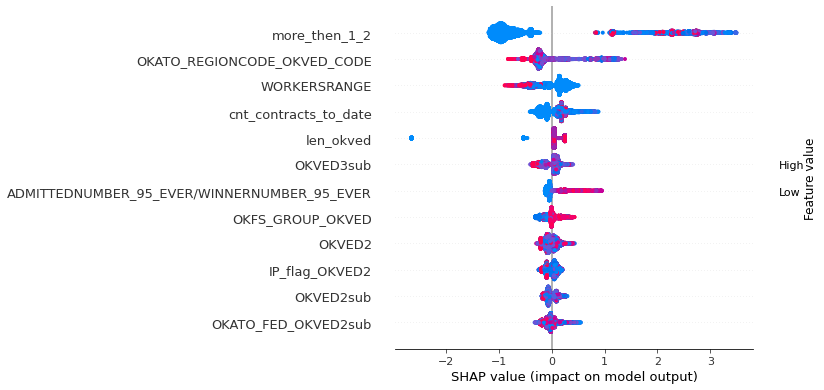

In [44]:
from shap import TreeExplainer, summary_plot

exp = TreeExplainer(lgb_model)
sv = exp.shap_values(X)
summary_plot(sv[1], X, max_display=12,auto_size_plot=True)

#### more_then_1_2:

Чем больше у клиента дней в прошлом, когда он заключил 2 или более контракта, тем выше вероятность предъявления по банковской гарантии.
Самый информативный количественный признак.

#### OKATO_REGIONCODE_OKVED_CODE: 

Существует множество категорий клиентов, с определённым ОКВЭД'ом и регионом, в которых клиент часто вынуждает контрагента обратиться в банк по предъявлению гарантии.
Самый информативный категориальный признак.

#### WORKERSRANGE:

Чем больше численность персонала клиента, тем ниже риск.

#### cnt_contracts_to_date:

Чем больше контрактов заключил ранее клиент, тем выше риск.

#### len_okved:

Чем детальней указан ОКВЭД, тем выше риск предъявления по гарантии. Риск низкий, если ОКВЭД отсутствует или указана только группа/подгруппа.

#### OKVED3sub:

Существует множество категорий клиентов, с определённой подгруппой ОКВЭД'а, в которых клиент чаще всего нарушает условия договора.

#### ADMITTEDNUMBER_95_EVER/WINNERNUMBER_95_EVER:

Чем выше отношение допусков к победам в тендерах, тем выше вероятность предъявления по банковской гарантии.
Говорит об активной, но маловыигрышной истории в тендерах.

#### OKFS_GROUP_OKVED:

Существует множество определнных категорий клиентов, с определённым классом ОКВЭД'ом, ОКФС, в которых клиент чаще всего нарушает условия договора.


#### stats_OKATO_REGIONCODE_mean:

Чем выше среднее ежедневное количество клиентов в категориях признака ОКАТО+регион, тем выше вероятность предъявления по банковской гарантии.

#### r3_ratio3_SIGN_DATE-DATEFIRSTREG/ADMITTEDNUMBER_95_EVER/ratio3_SIGN_DATE-DATEFIRSTREG/SIGNEDNUMBER_95_EVER:
    
Отношение среднего времени между допусками к тендеру к среднему времени между подписанием контракта играет немаловажную роль.
Чем ниже значение, тем меньше риск предъявления по гарантии.

Посмотрим на природу категориальных данных с другой стороны.
Для большей наглядности, визуализируем тренды накопления фактов предъявлений по гарантии в самых важных категориальных признаках.

In [46]:
def risk_trends(cat):
    print('Risk trends by {}'.format(cat))
    data2 = data.loc[data['TARGET']==1].copy()  #['OKATO_REGIONCODE_OKVED2']
    plot_df = pd.get_dummies(data2[[cat]], columns = [cat]).cumsum()
    top30 = pd.get_dummies(data2[['SIGN_DATE',cat]], columns = [cat]).sum(axis=0).sort_values(ascending=False)[:30].index
    plot_df[top30].plot(figsize=(20,10),title='Динамика накопления фактов предъявления по гарантии в каждой из 30 категорий')

    data2 = data.loc[data['TARGET']==1].drop_duplicates(['id_client','SIGN_DATE']).copy()  #['OKATO_REGIONCODE_OKVED2']
    plot_df = pd.get_dummies(data2[[cat]], columns = [cat]).cumsum()
    #top30 = pd.get_dummies(data2[['SIGN_DATE',cat]], columns = [cat]).sum(axis=0).sort_values(ascending=False)[:30].index
    plot_df[top30].plot(figsize=(20,10),title='Динамика накопления клиентов, по которым были предъявления по гарантии в каждой из 30 категорий')

Risk trends by OKATO_REGIONCODE_OKVED_CODE


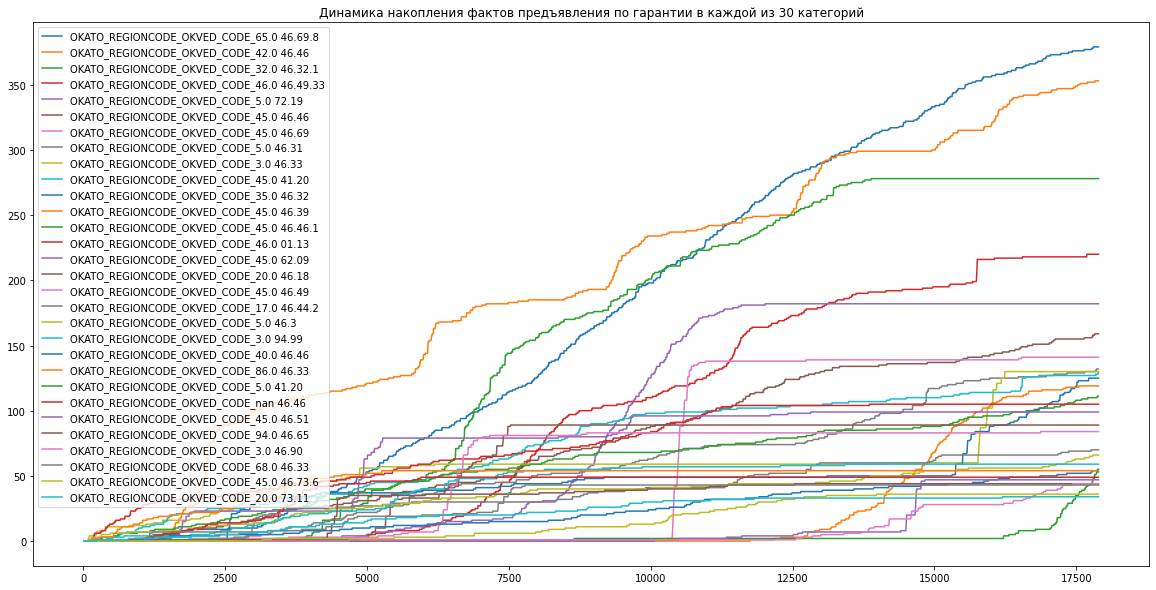

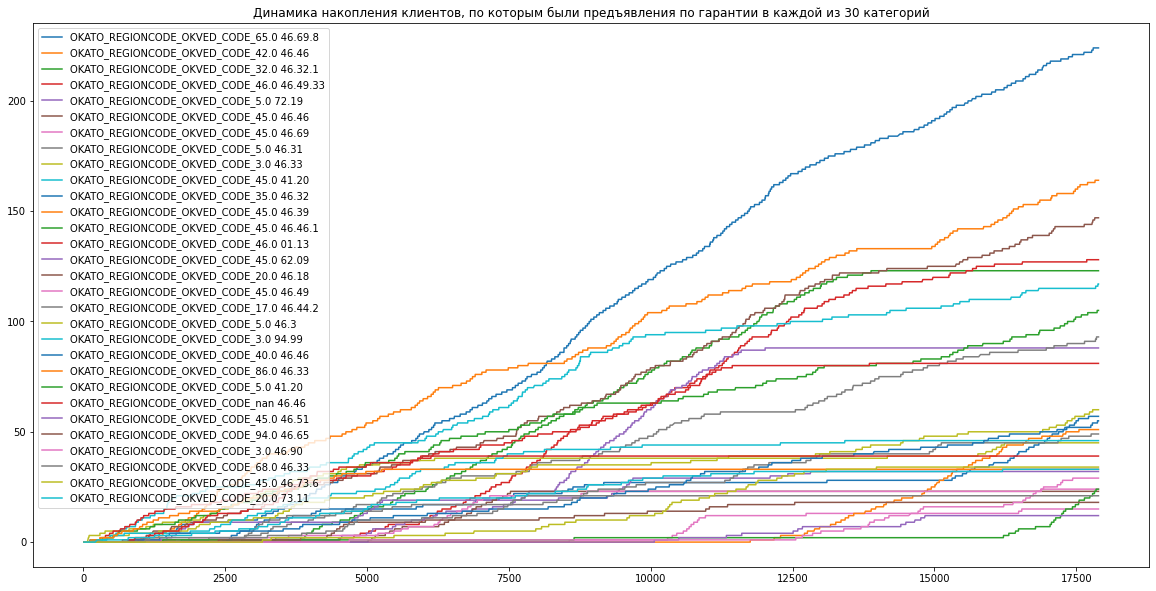

In [56]:
risk_trends('OKATO_REGIONCODE_OKVED_CODE')

Вывод: в ряде регионов работа с клиентами из оптовой торговли имеет наибольший риск.

Risk trends by OKVED3sub


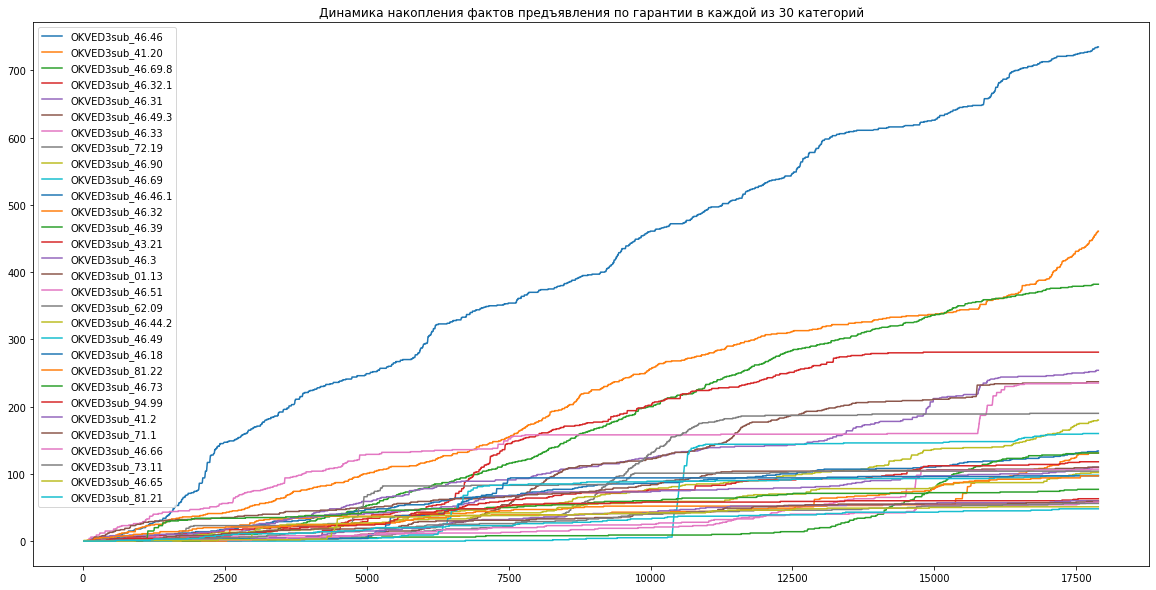

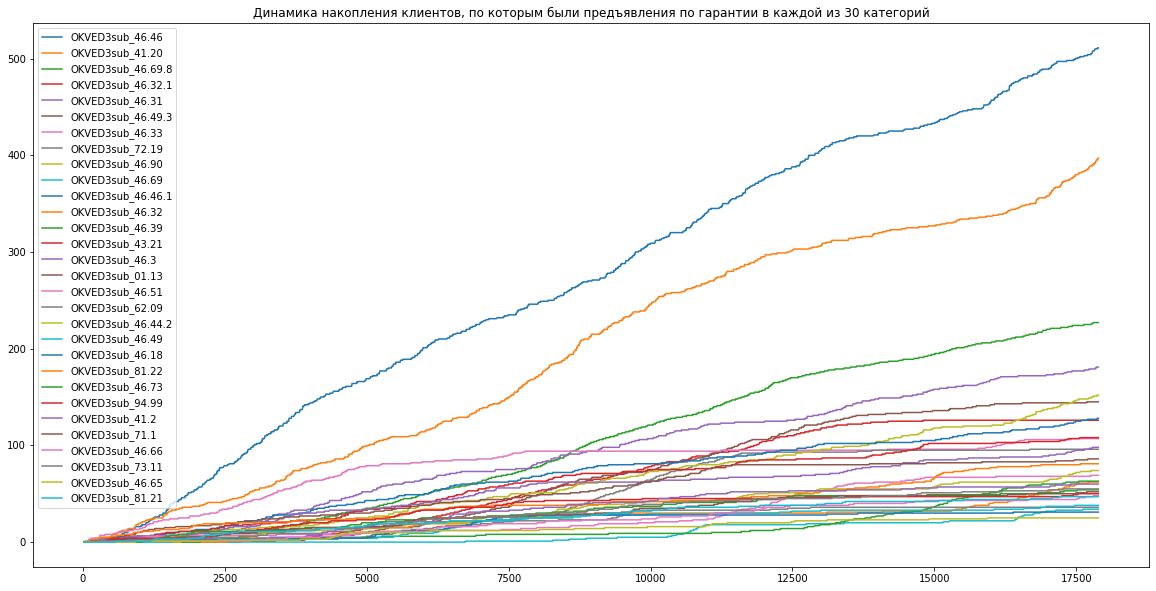

In [58]:
risk_trends('OKVED3sub')

Вывод: Клиенты с ОКВЭД'ом 41.20 (Строительство жилых и нежилых зданий) к концу исследуемого периода увеличили частоту предъявлений по гарантии.

#### Мы видим чёткие тренды в каждой категории и понимаем где основные объёмы предъявлений по гарантии, а также видим структуру их динамики.

Предложения:
* На основе "рисковых трендов", экстраполируя накопительную динамику, можно составлять краткосрочный прогноз распределения "плохих" клиентов/контрактов по категориям (для каждого топового кат. признака), например на неделю или месяц.
* Численность персонала играет немаловажную роль, поэтому необходимо отслеживать динамику изменения числа сотрудников по данным, например, СПАРК'а.
* Так как участие в аукционных днях является важной характеристикой клиента, то обязательно новое обучение модели после каждого такого дня, а подписание контракта лучше в следующие дни.
* Обогащение данными о характере участия клиента в тендерах и аукционных днях позволит улучшить качество модели.
* Детальный анализ всевозможной информации об ОКВЭД'е клиента: ОКВЭД'ы в прошлом, соответствует ли деятельность клиента его ОКВЭД'у, с какими другими неуказанными ОКВЭД'ами могла бы пересекаться деятельность компании, какие услуги и товар поставляет клиент и так далее безусловно повысит качество модели.